In [4]:
import pandas as pd 
import numpy as np
import plotly_express as px
import requests
import json
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

import spacy
nlp = spacy.load("es_core_news_sm")

## **EXTRACCIÓN.**

In [5]:
#Lectura de los portales de datos de provincias de Argentina
df_portales_provincias = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQa-vbZBCbYKkvhfxIkz2YqBm4jSG-zEuxRJbRHqw79r2NvYPINfpPvfMQGe6KBGvK7lR3XGjwjEVE6/pub?gid=0&single=true&output=csv')

#Filtro por las provincias que funcionan
df_portales_provincias = df_portales_provincias[df_portales_provincias['CONECTA']=='SI']

#Lectura de datos de ciudades
df_portales_ciudades = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQa-vbZBCbYKkvhfxIkz2YqBm4jSG-zEuxRJbRHqw79r2NvYPINfpPvfMQGe6KBGvK7lR3XGjwjEVE6/pub?gid=1408539218&single=true&output=csv')

#Filtro por las ciudades que funcionan
df_portales_ciudades = df_portales_ciudades[df_portales_ciudades['COMENTARIO']=='FUNCIONA']

#### *Funciones de mútliples consultas para extracción - DATASETS, TAGS, GRUPOS, ORGANIZACIONES*

In [4]:
def funcion_consulta(lugar:str,url:str,endpoint:str) -> pd.DataFrame:
    try: 
        url = f'{url}/api/action/{endpoint}'
        response = requests.request(method='GET',url=url).json()['result']
        print(f'Se generó la extracción para {lugar}: {len(response)} {endpoint} totales')
        return [lugar,response,len(response)]
    except:
        print(f'No se pudo para {lugar}')
        return [lugar,response,0]
    
def multiples_consultas(df:pd.DataFrame,endpoint:str) -> pd.DataFrame:

    print(F'\nEXTRACCIÓN DE {endpoint.upper()}\n')

    resultado = []

    for lugar in df.itertuples():
        try:
            registro = funcion_consulta(lugar=lugar[2],url=lugar[3],endpoint=endpoint)
            resultado.append(registro)
        except:
            print(f'No se pudo para {lugar}')

    return pd.DataFrame(resultado,columns=['LUGAR',f'RESPUESTA_{endpoint}','CANTIDAD'])

#### *Extracción - provincias.*

In [4]:
df_tags_provincias = multiples_consultas(df_portales_provincias,endpoint='tag_list')
df_datasets_provincias = multiples_consultas(df_portales_provincias,endpoint='package_list')
df_grupos_provincias = multiples_consultas(df_portales_provincias,endpoint='group_list')
df_organizaciones_provincias = multiples_consultas(df_portales_provincias,endpoint='organization_list')


EXTRACCIÓN DE TAG_LIST

Se generó la extracción para CABA: 371 tag_list totales
Se generó la extracción para BUENOS AIRES: 116 tag_list totales
Se generó la extracción para CORDOBA: 41 tag_list totales
Se generó la extracción para CHACO: 24 tag_list totales
Se generó la extracción para MENDOZA: 470 tag_list totales
Se generó la extracción para NEUQUEN: 98 tag_list totales
Se generó la extracción para SANTA FE: 138 tag_list totales
Se generó la extracción para TUCUMAN: 484 tag_list totales

EXTRACCIÓN DE PACKAGE_LIST

Se generó la extracción para CABA: 430 package_list totales
Se generó la extracción para BUENOS AIRES: 69 package_list totales
Se generó la extracción para CORDOBA: 630 package_list totales
Se generó la extracción para CHACO: 9 package_list totales
Se generó la extracción para MENDOZA: 195 package_list totales
Se generó la extracción para NEUQUEN: 19 package_list totales
Se generó la extracción para SANTA FE: 142 package_list totales
Se generó la extracción para TUCUMAN: 

#### *Extracción - ciudades.*

In [5]:
df_datasets_ciudades = multiples_consultas(df_portales_ciudades,endpoint='package_list')
df_tags_ciudades = multiples_consultas(df_portales_ciudades,endpoint='tag_list')
df_grupos_ciudades = multiples_consultas(df_portales_ciudades,endpoint='group_list')
df_organizaciones_ciudades = multiples_consultas(df_portales_ciudades,endpoint='organization_list')


EXTRACCIÓN DE PACKAGE_LIST

Se generó la extracción para CABA: 430 package_list totales
Se generó la extracción para CORDOBA: 69 package_list totales
Se generó la extracción para BAHIA BLANCA: 240 package_list totales
Se generó la extracción para MERCEDES: 306 package_list totales
Se generó la extracción para NEUQUEN: 19 package_list totales
Se generó la extracción para RAFAELA: 15 package_list totales
Se generó la extracción para RIVADAVIA: 0 package_list totales
Se generó la extracción para MENDOZA: 179 package_list totales
Se generó la extracción para TIGRE: 141 package_list totales
Se generó la extracción para CORRIENTES: 55 package_list totales
Se generó la extracción para LINCOLN: 142 package_list totales
Se generó la extracción para SAN LUIS: 9 package_list totales
Se generó la extracción para SANTA ROSA: 0 package_list totales
Se generó la extracción para GENERAL ALVARADO: 0 package_list totales
Se generó la extracción para PERGAMINO: 112 package_list totales
Se generó la extr

## **ANÁLISIS EXPLORATORIO**

### Análisis de la frecuencia de portales y datasets por provincia.

In [16]:
import plotly.subplots as sp
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = 'seaborn'

#Frecuencia de los portales por provincia
frecuencia_ciudades = df_portales_ciudades.groupby('PROVINCIA')\
    .size()\
        .reset_index(name='frecuencia_absoluta')\
            .sort_values('frecuencia_absoluta',ascending=False)

#MERGEO DE TABLAS POR PROVINCIAS CON LA DE RECURSOS ABSOLUTOS.
frecuencia_ciudades_mergeada = df_portales_ciudades.merge(right=df_datasets_ciudades,
                                                          how='left',
                                                          left_on='CIUDAD',
                                                          right_on='LUGAR')

#GENERO LA TRANSFORMACCIÓN PARA SÓLO QUEDARME CON EL DATO DE LA CANTIDAD TOTAL DE DATASETS POR PROVINCIA
frecuencia_ciudades_mergeada = frecuencia_ciudades_mergeada.groupby(by='PROVINCIA').sum().reset_index().sort_values(by='CANTIDAD',ascending=False)[['PROVINCIA','CANTIDAD']]

#GENERO LA VISUALIZACIÓN
figura = sp.make_subplots(specs=[[{'secondary_y':True}]])

figura.add_trace(go.Bar(x=frecuencia_ciudades_mergeada['PROVINCIA'],
                        y=frecuencia_ciudades_mergeada['CANTIDAD'],
                        name='Datasets totales por provincia',
                        marker=dict({'color':'darkred'}),
                        offset=-0.3,
                        text=frecuencia_ciudades_mergeada['CANTIDAD']
                        ),
                        secondary_y=True)


figura.add_trace(go.Bar(x=frecuencia_ciudades['PROVINCIA'],
                        y=frecuencia_ciudades['frecuencia_absoluta'],
                        name='Portales de datos por provincia',
                        marker=dict({'color':'darkblue'}),
                        offset=0,
                        text=frecuencia_ciudades['frecuencia_absoluta']
                        ),
                        secondary_y=False)

figura.update_traces(width=0.3) 

figura.update_yaxes(title_text= 'Cantidad de portales de datos por provincia',color='darkblue',secondary_y=False)
figura.update_yaxes(title_text= 'Cantidad acumulada de datasets por provincia',color='darkred',secondary_y=True)
figura.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5))
figura.update_layout(title='Comparación de Portales de Datos y Datasets por Provincia')

figura

### Exploratorio de los grupos por ciudad.

#### Exploración de los grupos por ciudad - Frecuencia absoluta.

In [114]:
#Genero la visualización de los temas.
fig = px.bar(df_grupos_ciudades.sort_values(by='CANTIDAD',ascending=False),
             x='LUGAR',
             y='CANTIDAD',
             text='CANTIDAD')

fig.update_yaxes(title_text='Frecuencia absoluta')
fig.update_xaxes(title_text='Ciudad')
fig.update_layout(title='Frecuencia de grupos por Ciudad')
fig.show()

#### Exploración de los grupos - Normalización.

In [149]:
#Genero el conjunto de grupos totales.
ciudades_universo_grupos = [grupo for lista_grupo in df_grupos_ciudades['RESPUESTA_group_list'] for grupo in lista_grupo]

In [150]:
#Cantidad de grupos totales extraidos
print(len(ciudades_universo_grupos))

141


In [151]:
#Calculo las frecuencias de cada uno de los tags sin normalizar
frecuencias = {}
for valor in ciudades_universo_grupos:
    if valor in frecuencias:
        frecuencias[valor] += 1
    else:
        frecuencias[valor] = 1

df_frecuencia_grupos = pd.DataFrame.from_dict(frecuencias, orient='index', columns=['Frecuencia']).sort_values(by='Frecuencia',ascending=False).reset_index(names=['grupo'])

In [152]:
#Cantidad de grupos unicos
df_frecuencia_grupos['grupo'].nunique()

101

In [162]:
fig = px.bar(df_frecuencia_grupos[:20],x='grupo',y='Frecuencia',text='Frecuencia',title='Frecuencia de aparición de cada grupo')

fig

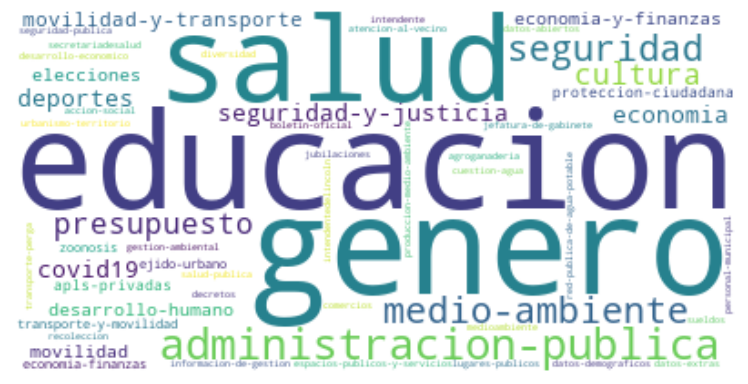

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Crear un DataFrame de ejemplo
df = df_frecuencia_grupos

# Crear una cadena con todas las palabras
palabras = ' '.join(df['grupo'])

# Crear un conjunto de stopwords en español
stopwords_es = set(STOPWORDS)
stopwords_es.update(['de', 'y', 'que', 'en', 'la', 'el', 'para'])  # Agregar stopwords adicionales si es necesario

# Crear el objeto WordCloud con fondo blanco
wordcloud = WordCloud(background_color='white', stopwords=stopwords_es)

# Generar el WordCloud con las frecuencias
wordcloud.generate_from_frequencies(df.set_index('grupo')['Frecuencia'])

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 4))

# Mostrar el WordCloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Ajustar el tamaño del WordCloud según la frecuencia
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### Matriz general

In [152]:
from herrramientas import Ckan

matriz_completa = pd.DataFrame(columns=['description',
 'format',
 'name',
 'created',
 'last_modified',
 'tags',
 'area',
 'organization',
 'grupo',
 'dataset'])

for portal in df_portales_ciudades.iterrows():
    url = portal[1][2]
    ckan = Ckan(url)

    nombre = portal[1][1].lower().replace(' ','_')

    matriz_especifica = ckan.df_recursos_totales()
    matriz_especifica['PROVINCIA'],matriz_especifica['LUGAR'] = portal[1][3],portal[1][1]

    matriz_completa = pd.concat([matriz_completa,matriz_especifica])

    print(f'se agregó la matriz {portal[1][1]}')
    
matriz_completa

se agregó la matriz CABA
se agregó la matriz CORDOBA
se agregó la matriz BAHIA BLANCA
se agregó la matriz MERCEDES
se agregó la matriz NEUQUEN
se agregó la matriz RAFAELA
se agregó la matriz RIVADAVIA
se agregó la matriz MENDOZA
se agregó la matriz TIGRE
se agregó la matriz CORRIENTES
se agregó la matriz LINCOLN
se agregó la matriz SAN LUIS
se agregó la matriz SANTA ROSA
se agregó la matriz GENERAL ALVARADO
se agregó la matriz PERGAMINO
se agregó la matriz EZEIZA


,description,format,name,created,last_modified,tags,area,organization,grupo,dataset,metadata_modified,PROVINCIA,LUGAR
0,Listado con informacion de contactos a la line...,CSV,Llamados 147 COVID,2020-07-14T20:24:32.156319,2022-12-30T02:00:02.003123,"[147, COVID-19, adultos mayores, atención ciud...",Ministerio de Salud,atencion-ciudadana,"[covid-19, salud]",147-covid,2023-05-22T12:00:05.267005,CABA,CABA
1,Cantidad total de años de escolaridad que es d...,CSV,Años de escolaridad esperados,2019-04-09T14:40:31.719970,2019-04-09T14:40:31.719970,[],Ministerio de Economía y Finanzas. Dirección G...,direccion-general-de-estadisticas-y-censos,[educacion],acceso-credenciales-educativas,2021-12-31T04:50:36.095017,CABA,CABA
2,Relación entre el porcentaje de mujeres de 10 ...,CSV,Brecha de analfabetismo,2019-04-09T14:48:47.378813,2019-04-09T14:48:47.378813,[],Ministerio de Economía y Finanzas. Dirección G...,direccion-general-de-estadisticas-y-censos,[educacion],acceso-credenciales-educativas,2021-12-31T04:55:44.449063,CABA,CABA
3,Porcentaje de población escolarizada en cada n...,CSV,Tasa neta de escolarización,2019-04-09T15:02:02.262366,2019-04-09T15:02:02.262366,[],Ministerio de Economía y Finanzas. Dirección G...,direccion-general-de-estadisticas-y-censos,[educacion],acceso-credenciales-educativas,2021-12-31T04:59:59.474934,CABA,CABA
4,Cantidad total de años de escolaridad que es d...,XLSX,Años de escolaridad esperados (XLSX),2019-04-09T14:40:31.719970,2019-04-09T14:40:31.719970,[],Ministerio de Economía y Finanzas. Dirección G...,direccion-general-de-estadisticas-y-censos,[educacion],acceso-credenciales-educativas,2021-12-31T05:01:20.377562,CABA,CABA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,Cantidad de Mujeres y Varones asistidos 2018-2022,XLS,Cantidad de Mujeres y Varones asistidos,2020-01-24T15:02:44.868056,2023-01-18T12:59:10.538389,"[genero, mujeres, noestassola, violencia, viol...",Dirección de Asistencia a la Mujer y a la familia,direccion-de-asistencia-a-la-mujer-y-a-la-familia,"[diversidad, datos-demograficos, seguridad]",violencia-de-genero,NaN,BUENOS AIRES,PERGAMINO
362,Detalle de las instituciones y causas por la q...,CSV,Derivaciones realizadas por la Dirección de As...,2021-01-14T17:25:08.512079,2023-01-18T12:47:56.857265,"[genero, mujeres, noestassola, violencia, viol...",Dirección de Asistencia a la Mujer y a la familia,direccion-de-asistencia-a-la-mujer-y-a-la-familia,"[diversidad, datos-demograficos, seguridad]",violencia-de-genero,NaN,BUENOS AIRES,PERGAMINO
363,Detalle de las instituciones y causas por la c...,XLS,Derivaciones realizadas por la Dirección de As...,2021-01-14T17:19:05.571799,2023-01-18T12:46:33.232741,"[genero, mujeres, noestassola, violencia, viol...",Dirección de Asistencia a la Mujer y a la familia,direccion-de-asistencia-a-la-mujer-y-a-la-familia,"[diversidad, datos-demograficos, seguridad]",violencia-de-genero,NaN,BUENOS AIRES,PERGAMINO
364,Cantidad de hijos que tiene la víctima,CSV,Cantidad de hijos que tiene la víctima,2021-01-15T15:07:52.538340,2023-01-18T12:42:36.195164,"[genero, mujeres, noestassola, violencia, viol...",Dirección de Asistencia a la Mujer y a la familia,direccion-de-asistencia-a-la-mujer-y-a-la-familia,"[diversidad, datos-demograficos, seguridad]",violencia-de-genero,NaN,BUENOS AIRES,PERGAMINO


#### Matriz de tags

In [153]:
matriz_tags = []

for fila in matriz_completa.iterrows():

    if len(fila[1][5]) == 1 and len(fila[1][8]) == 1:
        matriz_tags.append(
            [
                fila[1][5][0], #tag
                fila[1][6], #organizacion
                fila[1][8][0], #grupo
                fila[1][8], #Dataset
                fila[1][11], #provincia
                fila[1][12], #ciudad

             ]
        )

    if len(fila[1][5]) > 1 and len(fila[1][8]) == 1:
        for tag in fila[1][5]:
            matriz_tags.append(
            [
                tag, #tag
                fila[1][6], #organizacion
                fila[1][8], #grupo
                fila[1][9], #Dataset
                fila[1][11], #provincia
                fila[1][12], #ciudad

             ]
        )
            
matriz_tags = pd.DataFrame(matriz_tags,columns=['tags','organizacion','grupo','dataset','provincia','ciudad'])


# Tokenizar la columna de tags
matriz_tags['tags_tokenizados'] = matriz_tags['tags'].apply(lambda x: [token.text for token in nlp(x)])

matriz_tags['tags_lematizados'] = matriz_tags['tags'].apply(lambda x: [token.lemma_ for token in nlp(x)])

matriz_tags['tags_lematizados_unificados'] = matriz_tags['tags_lematizados'].apply(lambda x: ' '.join(x))

matriz_tags['grupo'] = matriz_tags['grupo'].apply(lambda x: x[0])

matriz_tags

,tags,organizacion,grupo,dataset,provincia,ciudad,tags_tokenizados,tags_lematizados,tags_lematizados_unificados
0,información pública,Ministerio de Gobierno. SS de Asuntos Político...,administracion-publica,acceso-informacion-publica,CABA,CABA,"[información, pública]","[información, público]",información público
1,ley 104,Ministerio de Gobierno. SS de Asuntos Político...,administracion-publica,acceso-informacion-publica,CABA,CABA,"[ley, 104]","[ley, 104]",ley 104
2,normas,Ministerio de Gobierno. SS de Asuntos Político...,administracion-publica,acceso-informacion-publica,CABA,CABA,[normas],[norma],norma
3,transparencia,Ministerio de Gobierno. SS de Asuntos Político...,administracion-publica,acceso-informacion-publica,CABA,CABA,[transparencia],[transparencia],transparencia
4,información pública,Ministerio de Gobierno. SS de Asuntos Político...,administracion-publica,acceso-informacion-publica,CABA,CABA,"[información, pública]","[información, público]",información público
...,...,...,...,...,...,...,...,...,...
11518,ingreso escolar,Secretaria de Salud,salud,vacunas-ingreso-escolas,BUENOS AIRES,PERGAMINO,"[ingreso, escolar]","[ingreso, escolar]",ingreso escolar
11519,vacunas,Secretaria de Salud,salud,vacunas-ingreso-escolas,BUENOS AIRES,PERGAMINO,[vacunas],[vacuna],vacuna
11520,CAPS,Secretaria de Salud,salud,vacunas-ingreso-escolas,BUENOS AIRES,PERGAMINO,[CAPS],[CAPS],CAPS
11521,ingreso escolar,Secretaria de Salud,salud,vacunas-ingreso-escolas,BUENOS AIRES,PERGAMINO,"[ingreso, escolar]","[ingreso, escolar]",ingreso escolar


In [154]:
frecuencia_tags_ciudad = pd.DataFrame(matriz_tags.groupby(by=['tags_lematizados_unificados','ciudad','grupo']).size()).reset_index()

frecuencia_tags_ciudad.columns = ['tags_lematizados_unificados','ciudad','grupo','frecuencia']

frecuencia_tags_ciudad = frecuencia_tags_ciudad.sort_values(by='frecuencia',ascending=False)

In [155]:
import plotly.express as px

# Crear el gráfico de barras de frecuencia de términos lematizados por ciudad
figura = px.scatter(frecuencia_tags_ciudad[:50], x='ciudad', y='frecuencia', color='tags_lematizados_unificados', title='Frecuencia de términos lematizados por Ciudad',text='tags_lematizados_unificados')

figura.update_layout(showlegend=False)

figura

#### Matriz de grupos

In [156]:
#Me quedo solo con los datos que son grupos mayores a 1
matriz_completa_GRUPOS = matriz_completa[(matriz_completa['grupo'].apply(lambda x: len(x)>=1))]

matriz_completa_GRUPOS['grupo'] = matriz_completa_GRUPOS['grupo'].apply(lambda x: x[0])

matriz_completa_GRUPOS

/var/folders/pr/p7nx1g2d6nvg23wbvp3nnb580000gn/T/ipykernel_38005/3239595759.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,description,format,name,created,last_modified,tags,area,organization,grupo,dataset,metadata_modified,PROVINCIA,LUGAR
0,Listado con informacion de contactos a la line...,CSV,Llamados 147 COVID,2020-07-14T20:24:32.156319,2022-12-30T02:00:02.003123,"[147, COVID-19, adultos mayores, atención ciud...",Ministerio de Salud,atencion-ciudadana,covid-19,147-covid,2023-05-22T12:00:05.267005,CABA,CABA
1,Cantidad total de años de escolaridad que es d...,CSV,Años de escolaridad esperados,2019-04-09T14:40:31.719970,2019-04-09T14:40:31.719970,[],Ministerio de Economía y Finanzas. Dirección G...,direccion-general-de-estadisticas-y-censos,educacion,acceso-credenciales-educativas,2021-12-31T04:50:36.095017,CABA,CABA
2,Relación entre el porcentaje de mujeres de 10 ...,CSV,Brecha de analfabetismo,2019-04-09T14:48:47.378813,2019-04-09T14:48:47.378813,[],Ministerio de Economía y Finanzas. Dirección G...,direccion-general-de-estadisticas-y-censos,educacion,acceso-credenciales-educativas,2021-12-31T04:55:44.449063,CABA,CABA
3,Porcentaje de población escolarizada en cada n...,CSV,Tasa neta de escolarización,2019-04-09T15:02:02.262366,2019-04-09T15:02:02.262366,[],Ministerio de Economía y Finanzas. Dirección G...,direccion-general-de-estadisticas-y-censos,educacion,acceso-credenciales-educativas,2021-12-31T04:59:59.474934,CABA,CABA
4,Cantidad total de años de escolaridad que es d...,XLSX,Años de escolaridad esperados (XLSX),2019-04-09T14:40:31.719970,2019-04-09T14:40:31.719970,[],Ministerio de Economía y Finanzas. Dirección G...,direccion-general-de-estadisticas-y-censos,educacion,acceso-credenciales-educativas,2021-12-31T05:01:20.377562,CABA,CABA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,Cantidad de Mujeres y Varones asistidos 2018-2022,XLS,Cantidad de Mujeres y Varones asistidos,2020-01-24T15:02:44.868056,2023-01-18T12:59:10.538389,"[genero, mujeres, noestassola, violencia, viol...",Dirección de Asistencia a la Mujer y a la familia,direccion-de-asistencia-a-la-mujer-y-a-la-familia,diversidad,violencia-de-genero,NaN,BUENOS AIRES,PERGAMINO
362,Detalle de las instituciones y causas por la q...,CSV,Derivaciones realizadas por la Dirección de As...,2021-01-14T17:25:08.512079,2023-01-18T12:47:56.857265,"[genero, mujeres, noestassola, violencia, viol...",Dirección de Asistencia a la Mujer y a la familia,direccion-de-asistencia-a-la-mujer-y-a-la-familia,diversidad,violencia-de-genero,NaN,BUENOS AIRES,PERGAMINO
363,Detalle de las instituciones y causas por la c...,XLS,Derivaciones realizadas por la Dirección de As...,2021-01-14T17:19:05.571799,2023-01-18T12:46:33.232741,"[genero, mujeres, noestassola, violencia, viol...",Dirección de Asistencia a la Mujer y a la familia,direccion-de-asistencia-a-la-mujer-y-a-la-familia,diversidad,violencia-de-genero,NaN,BUENOS AIRES,PERGAMINO
364,Cantidad de hijos que tiene la víctima,CSV,Cantidad de hijos que tiene la víctima,2021-01-15T15:07:52.538340,2023-01-18T12:42:36.195164,"[genero, mujeres, noestassola, violencia, viol...",Dirección de Asistencia a la Mujer y a la familia,direccion-de-asistencia-a-la-mujer-y-a-la-familia,diversidad,violencia-de-genero,NaN,BUENOS AIRES,PERGAMINO


In [165]:
round(matriz_completa_GRUPOS.groupby(by='grupo').size().sort_values(ascending=False)/matriz_completa_GRUPOS.shape[0]*100,2)[:10]

grupo
administracion-publica    13.08
medio-ambiente             5.70
cultura-y-turismo          5.69
urbanismo-y-territorio     5.50
genero                     5.11
seguridad                  4.55
movilidad                  4.46
decretos                   3.85
economia-y-finanzas        3.60
covid19                    3.48
dtype: float64

In [177]:
agrupado_grupos = matriz_completa_GRUPOS.groupby(by=['grupo','LUGAR']).size().reset_index().sort_values(by=0,ascending=False)

agrupado_grupos.columns = ['grupo','ciudad','frecuencia']

figura = px.scatter(agrupado_grupos[:50],x='ciudad',y='frecuencia',text='grupo')


figura.show()

#### UNIVERSO DE GRUPOS Y TAGS POR CIUDAD.

In [198]:
matriz_completa_cruzada = matriz_completa[(matriz_completa['grupo'].apply(lambda x: len(x)>=1))]

matriz_completa_cruzada['grupo'] = matriz_completa_cruzada['grupo'].apply(lambda x: x[0])

matriz_completa_cruzada = matriz_completa_cruzada[(matriz_completa_cruzada['tags'].apply(lambda x: len(x)>=1))]

grupo_tags = matriz_completa_cruzada.groupby(by=["grupo",'LUGAR'])["tags"].apply(list).reset_index()

grupo_tags['tags_desagregados'] = grupo_tags['tags'].apply(lambda x: list(set([item for sublist in x for item in sublist])))


/var/folders/pr/p7nx1g2d6nvg23wbvp3nnb580000gn/T/ipykernel_38005/367955458.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [203]:
grupo_tags['grupo'].value_counts(ascending=False)[:10]

grupo
educacion                 6
administracion-publica    5
genero                    5
medio-ambiente            5
salud                     5
cultura                   3
seguridad                 3
movilidad-y-transporte    2
desarrollo-humano         2
presupuesto               2
Name: count, dtype: int64

In [206]:
grupo_tags[['grupo','LUGAR','tags_desagregados']]

,grupo,LUGAR,tags_desagregados
0,accion-social,LINCOLN,"[unidades, Fondo, mi bebe, Sostenible, 2018, f..."
1,actividad-economica,NEUQUEN,"[compras, gas, mineria, prestamos, producción,..."
2,administracion-publica,CABA,"[seguridad, matafuegos, dictamenes, divorcios,..."
3,administracion-publica,CORDOBA,"[legislación, información geográfica, ips, dni..."
4,administracion-publica,MENDOZA,"[Consorcios, seguridad, habitantes, DDJJ Funci..."
...,...,...,...
116,transporte-y-movilidad,CORRIENTES,"[transporte, multas, licencias, sac, movilidad..."
117,turismo,BAHIA BLANCA,"[reuniones, ferias, turismo, congresos, conven..."
118,urbanismo-territorio,MENDOZA,"[Cuencas Hidrográficas, Estaciones Hidrometeor..."
119,urbanismo-y-territorio,CABA,"[urbanismo-territorio, estadística, urbanismo,..."


In [211]:
grupo_tags[grupo_tags['grupo']=='administracion-publica']

,grupo,LUGAR,tags,tags_desagregados
2,administracion-publica,CABA,"[[información pública, ley 104, normas, transp...","[seguridad, matafuegos, dictamenes, divorcios,..."
3,administracion-publica,CORDOBA,"[[Boletín Oficial, decretos, legislación, leye...","[legislación, información geográfica, ips, dni..."
4,administracion-publica,MENDOZA,"[[acequias], [acequias], [informe aip], [infor...","[Consorcios, seguridad, habitantes, DDJJ Funci..."
5,administracion-publica,NEUQUEN,"[[Compras y Contrataciones, Proveedores del Es...","[compras, Organismos, Municipios, Organizacion..."
6,administracion-publica,PERGAMINO,"[[147, atencion a vecinos, reclamos], [147, at...","[agrupamiento, 147, acceso a la información pú..."


In [247]:
matriz_tags_lematizados_agrupados = matriz_tags.groupby(by=['tags_lematizados_unificados','grupo','ciudad']).size().sort_values(ascending=False).reset_index()

matriz_tags_lematizados_agrupados.columns = ['tags_lematizados','grupo','ciudad','frecuencia']

In [250]:
px.scatter(matriz_tags_lematizados_agrupados[:50],x='ciudad',y='frecuencia',text='tags_lematizados',color='grupo',size='frecuencia')

In [282]:
administracion_publica = matriz_tags_lematizados_agrupados[matriz_tags_lematizados_agrupados['grupo']=='administracion-publica']
administracion_publica['ciudad'].unique()

array(['CABA', 'PERGAMINO', 'CORDOBA', 'MENDOZA', 'NEUQUEN'], dtype=object)

In [326]:
df = administracion_publica
top_10_tags_por_lugar = df.groupby("ciudad").apply(lambda x: x.nlargest(10, "frecuencia")).reset_index(drop=True)
df = top_10_tags_por_lugar
df.columns = ['tags_lematizados','grupo','LUGAR','frecuencia']

In [327]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Filtrar el dataframe por lugar
lugares = df['LUGAR'].unique()

# Crear figura de subplots con una sola columna
fig = make_subplots(rows=1, cols=len(lugares), subplot_titles=lugares)

# Iterar sobre cada lugar y crear el gráfico de barras correspondiente
for i, lugar in enumerate(lugares):
    datos_lugar = df[df['LUGAR'] == lugar]
    
    fig.add_trace(
        go.Bar(x=datos_lugar['tags_lematizados'], y=datos_lugar['frecuencia'], name=lugar,text=datos_lugar['frecuencia']),
        row=1, col=i+1
    )

# Configurar diseño de los subplots
fig.update_layout(height=400, width=300*len(lugares), showlegend=False, title="Administración Pública y Tags Asociados")
fig.update_xaxes(title_text="Tags", tickangle=45, nticks=len(df['tags_lematizados'].unique()))

# Mostrar el gráfico
fig.show()



In [336]:
matriz_tags_lematizados_agrupados.groupby(by='grupo').size().sort_values(ascending=False)[:20]

grupo
medio-ambiente                127
administracion-publica        116
salud                         101
movilidad                      56
decretos                       45
c                              45
educacion                      44
m                              44
gobierno                       42
urbanismo-y-territorio         41
economia-y-finanzas            40
datos-demograficos             38
sueldos                        36
economia                       36
seguridad                      34
cultura                        34
ejido-urbano                   32
cultura-y-turismo              30
d                              30
obras-y-servicios-publicos     29
dtype: int64

In [337]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

administracion_publica = matriz_tags_lematizados_agrupados[matriz_tags_lematizados_agrupados['grupo']=='educacion']
administracion_publica['ciudad'].unique()


df = administracion_publica
top_10_tags_por_lugar = df.groupby("ciudad").apply(lambda x: x.nlargest(10, "frecuencia")).reset_index(drop=True)
df = top_10_tags_por_lugar
df.columns = ['tags_lematizados','grupo','LUGAR','frecuencia']


# Filtrar el dataframe por lugar
lugares = df['LUGAR'].unique()

# Crear figura de subplots con una sola columna
fig = make_subplots(rows=1, cols=len(lugares), subplot_titles=lugares)

# Iterar sobre cada lugar y crear el gráfico de barras correspondiente
for i, lugar in enumerate(lugares):
    datos_lugar = df[df['LUGAR'] == lugar]
    
    fig.add_trace(
        go.Bar(x=datos_lugar['tags_lematizados'], y=datos_lugar['frecuencia'], name=lugar,text=datos_lugar['frecuencia']),
        row=1, col=i+1
    )

# Configurar diseño de los subplots
fig.update_layout(height=400, width=300*len(lugares), showlegend=False, title="Administración Pública y Tags Asociados")
fig.update_xaxes(title_text="Tags", tickangle=45, nticks=len(df['tags_lematizados'].unique()))

# Mostrar el gráfico
fig.show()



In [1]:
10/14

0.7142857142857143

In [3]:
25/36

0.6944444444444444